# BLEU notes and implementation

**This notebook demostrates the basic idea in [BLEU: a Method for Automatic Evaluation of Machine Translation](https://www.aclweb.org/anthology/P02-1040.pdf). The efficiency of the algorithm is not in first consideration.**

### Ideas in section *2.1 Modified n-gram precision*
> We formalize this intuition as the modified unigram precision. To compute this, one first counts the maximum number of times a word occurs in any **single reference translation**. Next, one clips the total count of each candidate word by its maximum reference count, adds these clipped counts up, and divides by the total (unclipped) number of candidate words.

In [1]:
import numpy as np

def _mostOccurSentenceOfAWord(word, references):
    """
    Description:
        Returns the sentence which word occurs most and how many time this word occurs in this sentence
    Inputs:
        word: word -- a single word in candidate sentence
        references: list of sentence -- references sentences
    Returns:
        mostOccurs: sentence -- the sentence which the word occurs most times.
        mostOccursTimes: integer -- how many times does word occur in mostOccurs
    """
    counts = list(map(lambda reference: reference.count(word), references))
    def argmax(L):
        return np.argmax(np.array(L)) # np.argmax will return the first one index
    mostOccursIndex = argmax(counts)
    mostOccurs = references[mostOccursIndex]
    mostOccursTimes = counts[mostOccursIndex]
    return mostOccurs, mostOccursTimes

$$Count_{clip}=min(Count, Max\_Ref\_Count)$$

In [2]:
def modifiedUnigramPrecision(candidate, references, returnCounts=False):
    """
    Description:
        Returns the modified unigram precision, or (count_clip, numCandidateUniGrams) pair
    Inputs:
        candidate: sentence -- candidate sentence
        references: list of sentence -- references sentences
        returnCounts: boolean -- False to return precision, True to return counts
    Returns:
        modifiedUnigramPrecision: float -- modified unigram precision defined in paper
        OR
        (count_clip, numCandidateUniGrams):
            countClip: int -- count_clip in paper
            numCandidateUniGrams: int -- number of candidate unigrams
    """
    countClip = 0
    for word in set(candidate):
        _, mostOccursTimes = _mostOccurSentenceOfAWord(word, references)
        countClip += min(candidate.count(word), mostOccursTimes)
    numCandidateUniGrams = len(candidate)
    return  (countClip, numCandidateUniGrams) if returnCounts else (countClip/numCandidateUniGrams)

> Modified n-gram precision is computed similarly for any n: all candidate n-gram counts and their
corresponding maximum reference counts are collected. The candidate counts are clipped by their
corresponding reference maximum value, summed, and divided by the total number of candidate n-grams.

Treat n-gram as a single word!

In [3]:
def modifiedNGramPrecision(n, candidate, references, returnCounts=False):
    """
    Description:
        Returns the modified n-gram precision or (count_clip, numCandidateNGrams) pair using modifiedUnigramPrecision()
    Inputs:
        n: int -- n for n-gram
        candidate: sentence -- candidate sentence
        references: list of sentence -- references sentences
    Returns:
        modifiedNGramPrecision: float -- modified n-gram precision defined in paper
        OR
        (count_clip, numCandidateNGrams):
            countClip: int -- count_clip in paper
            numCandidateNGrams: int -- number of candidate n-grams
    """    
    def sentenceToNGrams(n, sentence):
        nGrams = []
        for idx in range(len(sentence)-n+1):
            ngram = " ".join(sentence[idx:idx+n])
            nGrams.append(ngram)
        return nGrams
    
    candidateGrams = sentenceToNGrams(n, candidate)
    referencesGrams = list(map(lambda ref: sentenceToNGrams(n, ref), references))
    countClip, numCandidateNGrams = modifiedUnigramPrecision(candidateGrams, referencesGrams, returnCounts=True)
    return (countClip, numCandidateNGrams) if returnCounts else (countClip/numCandidateNGrams)

In [4]:
candidate1 = "It is a guide to action which ensures that the military always obeys the commands of the party".split()
candidate2 = "It is to insure the troops forever hearing the activity guidebook that party direct".split()
references = ["It is a guide to action that ensures that the military will forever heed Party commands".split(),
            "It is the guiding principle which guarantees the military forces always being under the command of the Party".split(),
            "It is the practical guide for the army always to heed the directions of the party".split()]

Test modifiedUnigramPrecision

In [5]:
modifiedUnigramPrecision(candidate1, references) #  Section 2.1

0.9444444444444444

In [6]:
17/18

0.9444444444444444

In [7]:
modifiedUnigramPrecision(candidate2, references) #  Section 2.1

0.5714285714285714

In [8]:
8/14

0.5714285714285714

In [9]:
modifiedUnigramPrecision(references[0], references) #  Section 2.1

1.0

In [10]:
modifiedUnigramPrecision(references[1], references) #  Section 2.1

1.0

In [11]:
modifiedUnigramPrecision(references[2], references) #  Section 2.1

1.0

Test modifiedNGramPrecision

In [12]:
modifiedNGramPrecision(2, candidate1, references) #  Section 2.1

0.5882352941176471

In [13]:
10/17

0.5882352941176471

In [14]:
modifiedNGramPrecision(2, candidate2, references) #  Section 2.1

0.07692307692307693

In [15]:
1/13

0.07692307692307693

### ideas in section *2.1.1 Modiﬁed n-gram precision on blocks of text*

> We first compute the n-gram matches sentence by sentence. Next, we add the clipped n-gram
counts for all the candidate sentences and divide by the number of candidate n-grams in the test corpus to compute a modiﬁed precision score, $p_n$, for the entire test corpus.


$$ p_n = \frac{\sum_{\mathcal{C}\in{Candidates}} \sum_{n-gram\in\mathcal{C}} Count_{clip}(n-gram)}
          {\sum_{\mathcal{C}'\in{Candidates}} \sum_{n-gram'\in\mathcal{C}'} Count(n-gram')} $$

In [16]:
def modifiedPrecisionScore(n, candidates, referencesList):
    """
    Description:
        Returns p_n in paper.
    Inputs:
        n: int -- n for n-gram
        candidates: list of sentence -- candidate sentences
        referencesList: list of list of sentence -- list of references sentences
    Returns:
        p_n: float -- p_n in paper
    """   
    totalCountClip = 0
    totalCount = 0
    for idx in range(len(candidates)):
        CountClip, Count = modifiedNGramPrecision(n, candidates[idx], referencesList[idx], returnCounts=True)
        totalCountClip += CountClip
        totalCount += Count
    p_n = totalCountClip/totalCount
    return p_n

In [17]:
candidates=[candidate2, candidate1]
referencesList = [references, references]

In [18]:
modifiedPrecisionScore(2, candidates, referencesList)

0.36666666666666664

### ideas in section *2.1.3 Combining the modiﬁed n-gram precisions*
BLEU uses the average logarithm with uniform weights, which is equivalent to using the geometric mean of the modiﬁed n-gram precisions

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

<Container object of 9 artists>

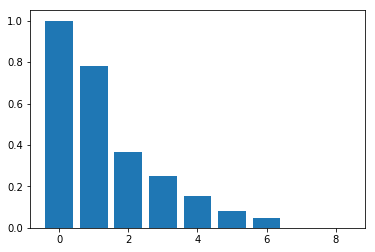

In [20]:
maxGram = 9
plt.bar(range(maxGram), np.array([modifiedPrecisionScore(i, candidates, referencesList) for i in range(maxGram)]))

###  ideas in section *2.2.2 Sentence brevity penalty*

Candidate translations longer than their references are already penalized by the modified n-gram precision measure: there is no need to penalize them again.  

 We call the closest reference sentence length the **“best match length.”**  
 
If we computed the brevity penalty sentence by sentence and averaged the penalties, then length deviations on short sentences would be punished harshly.  


Instead, we compute the brevity penalty over the **entire corpus** to allow some freedom at the sentence level. We first compute the test corpus’ *effective reference length*, $$r$$, by summing the *best match lengths* for each candidate sentence in the **corpus**.  

 We choose the brevity penalty to be a decaying exponential in $$\frac{r}{c}$$, where $c$ is the total length of the candidate translation corpus.  
 
We first compute the geometric average of the modified n-gram precisions, $p_n$, using n-grams up to length $N$ and positive weights $w_n$ summing to one. Next, we compute the brevity penalty BP,
$$BP = 1 \quad \quad \quad if c>r \\ \quad \quad \quad e^{(1-r/c)} \quad if c\le r
$$
Then,
$$BLEU=BP\cdot \exp(\sum^N_{n=1}\omega_n \log p_n)$$
OR
$$ log BLEU = min(1-\frac{r}{c}, 0) + \sum^N_{n=1} \omega _n log p_n$$
In our baseline, we use $N = 4$ and uniform weights $\omega_n = 1/N$.

In [21]:
def BLEU(n, candidates, referencesList):
    """
    Description:
        Returns BLEU in paper, with uniform weight \omega_n=1/N.
    Inputs:
        n: int -- n for max n-gram
        candidates: list of sentence -- candidate sentences
        referencesList: list of list of sentence -- list of references sentences
    Returns:
        BLEU: float -- BLEU score
    """   
    def bestMatchLength(candLen, refLens):
        matchLen = list(map(lambda refLen: abs(candLen-refLen), refLens))
        return refLens[np.argmin(matchLen)]
    
    candLens = [len(candidate) for candidate in candidates]
    refLenLists = [[len(reference) for reference in references] for references in referencesList]
    
    bestMatchLengths = [bestMatchLength(candLens[idx], refLenLists[idx]) for idx in range(len(candidates))]
    r = sum(bestMatchLengths)     
    c = sum(candLens)

    if c>r:
        BP = 1
    else:
        BP = np.exp(1-(r/c))
    
    P_n = [modifiedPrecisionScore(i, candidates, referencesList) for i in range(1, n+1)]
    logP_n = list(map(lambda x: np.log(x), P_n)) # occasionally encounter log(0) when test short candidates with big N
    geometricMean = np.exp(sum(logP_n)/n)
    BLEU = BP*geometricMean
    return BLEU

Test: Scores should grow monotonously.  
In the paper candidate1 is a better translation than candidate2.

In [22]:
candidates=[candidate2, candidate2]
referencesList = [references, references]

BLEU(4, candidates, referencesList)

D:\Applications\anaconda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


0.0

In [23]:
candidates=[candidate2, candidate1]
referencesList = [references, references]

BLEU(4, candidates, referencesList)

0.3043537261305561

In [24]:
candidates=[candidate1, candidate2]
referencesList = [references, references]

BLEU(4, candidates, referencesList)

0.3043537261305561

In [25]:
candidates=[candidate1, candidate1]
referencesList = [references, references]

BLEU(4, candidates, referencesList)

0.5045666840058485

In [26]:
candidates=[candidate1, references[0]]
referencesList = [references, references]

BLEU(4, candidates, referencesList)

0.7534483667732512

In [27]:
candidates=[references[0], references[0]]
referencesList = [references, references]

BLEU(4, candidates, referencesList)

1.0